In [2]:
from fastai.data.all import *
from fastai.vision.all import *
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.las import *
from enveco.models.inception3dv3 import *
from enveco.tabular import *
from fastai.callback.progress import ShowGraphCallback

# Read data

In [3]:
basedir = Path('../../../andras/ml/AV_leafon/')

train_df = pd.read_csv(basedir/'AV.leaf.on.train.csv')
valid_df = pd.read_csv(basedir/'AV.leaf.on.val.csv')
train_df['is_val'] = False
valid_df['is_val'] = True

df = pd.concat((train_df, valid_df))

df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v.ma,v.ku,v.lp,myear,filename.1,a.date.1,a.window.1,filename.2,a.date.2,a.window.2,v.lp.proc,is_val
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,False
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,False
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,False
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,False
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,False


In [4]:
df.v.describe()

count    1269.000000
mean      146.608771
std        87.840874
min         2.310000
25%        81.350000
50%       132.600000
75%       191.380000
max       867.350000
Name: v, dtype: float64

In [5]:
dls = VoxelDataLoaders.from_df(df, path=basedir, folder='AV_las/', bin_voxels=True, bottom_voxels=False, mask_plot=True,
                               y_block=RegressionBlock(), 
                               label_col='v', fn_col='sampleplotid', bs=32,
                               batch_tfms=[DihedralItem])

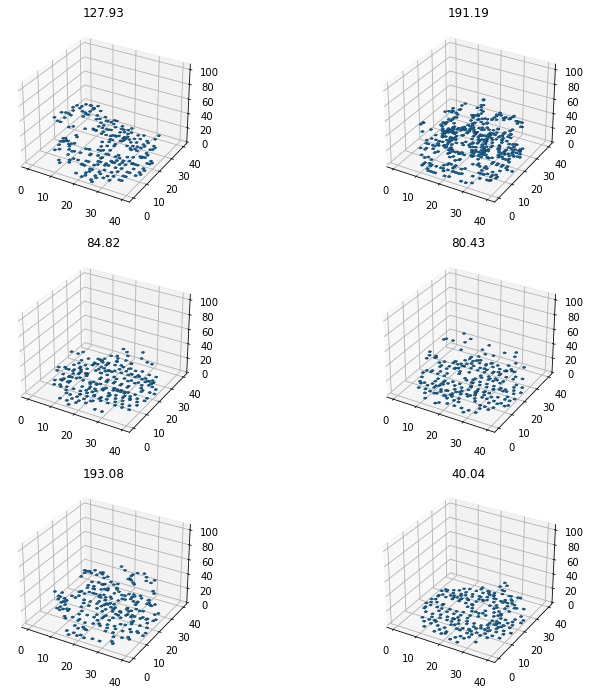

In [6]:
dls.show_batch()

In [7]:
dls.one_batch()

(VoxelImage size=32x1x105x40x40,
 tensor([244.4000, 175.0300,  68.9900, 270.7400,  39.0500, 222.0700,  64.2200,
         166.0000,  85.9600, 147.3700,  95.8500, 261.8000, 178.2400,  33.9500,
         119.4200,  54.2500, 280.7800,  67.7300, 263.9500, 204.1100, 202.3500,
          60.3400, 131.3800, 254.8300, 175.3500, 512.2000,  60.5400,   6.7600,
         107.2100, 135.4900, 133.6000, 166.2700], device='cuda:0'))

# Learner

Get predefined model.

In [8]:
inception = Inception3dV3(num_classes=dls.c, init_weights=True)


Create learner.

In [9]:
inc_learner = Learner(dls, inception, path='.', metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,900))

In [10]:
inc_learner.summary()

Inception3dV3 (Input shape: ['32 x 1 x 105 x 40 x 40'])
Layer (type)         Output Shape         Param #    Trainable 
Conv3d               32 x 32 x 52 x 20 x  384        True      
________________________________________________________________
BatchNorm3d          32 x 32 x 52 x 20 x  64         True      
________________________________________________________________
Conv3d               32 x 32 x 50 x 19 x  12,288     True      
________________________________________________________________
BatchNorm3d          32 x 32 x 50 x 19 x  64         True      
________________________________________________________________
Conv3d               32 x 64 x 50 x 19 x  24,576     True      
________________________________________________________________
BatchNorm3d          32 x 64 x 50 x 19 x  128        True      
________________________________________________________________
MaxPool3d            32 x 64 x 50 x 19 x  0          False     
__________________________________________

Search for a good learning rate

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.019054606556892395)

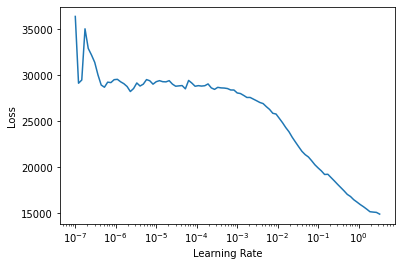

In [11]:
inc_learner.lr_find()

Fit with one cycle scheduling.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,28229.714844,27333.667969,165.328979,116.581795,-143.663605,-101.304443,143.663605,-3.058376,00:16
1,25632.271484,26647.335938,163.240112,115.108826,-146.100540,-103.022850,146.100525,-2.956472,00:15
2,21194.798828,10715.475586,103.515579,72.994057,-94.213326,-66.434563,94.362503,-0.590984,00:15
3,16284.706055,17916.228516,133.851517,94.385452,-119.972404,-84.598587,119.972397,-1.660118,00:15
4,11993.728516,11930.361328,109.226196,77.020897,-98.310364,-69.323586,98.324669,-0.771365,00:15
5,8453.761719,4554.761719,67.488976,47.589878,-56.689747,-39.974796,57.342880,0.323730,00:15
6,5858.574219,3179.814697,56.389851,39.763325,33.366367,23.528307,41.871983,0.527876,00:15
7,4013.981201,1528.089722,39.090790,27.564886,-25.500645,-17.981789,31.125000,0.773116,00:15
8,3064.999512,1967.355347,44.354877,31.276857,6.251011,4.407903,30.283411,0.707896,00:15
9,2425.009033,4062.677734,63.739136,44.945675,-49.153965,-34.660938,50.131466,0.396793,00:15


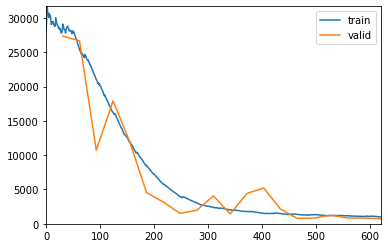

In [12]:
inc_learner.fit_one_cycle(20, max_lr=1e-2, cbs=ShowGraphCallback())

# See results

In [13]:
reg_interp = RegressionInterpretation.from_learner(inc_learner, ds_idx=1)

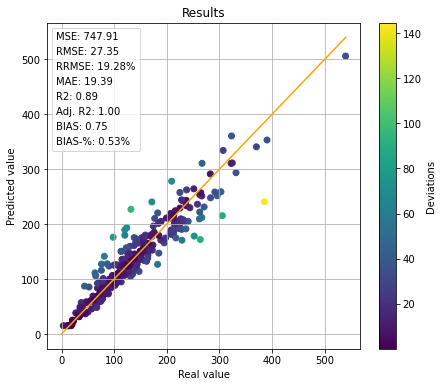

In [14]:
reg_interp.plot_results()
plt.show()

In [15]:
test_df = pd.read_csv(basedir/'AV.leaf.on.test.csv')

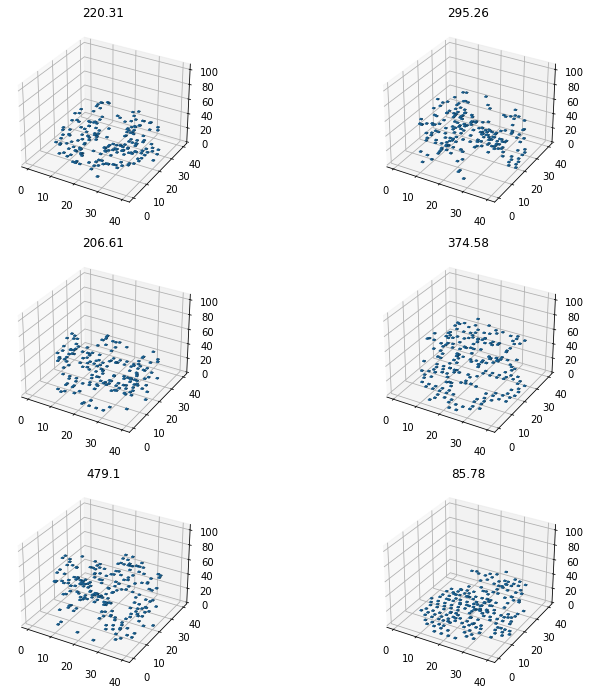

In [34]:
test_dl.show_batch()

In [32]:
test_dl = inc_learner.dls.test_dl(test_df, with_labels=True)

In [35]:
test_interp = RegressionInterpretation.from_learner(inc_learner, dl=test_dl)

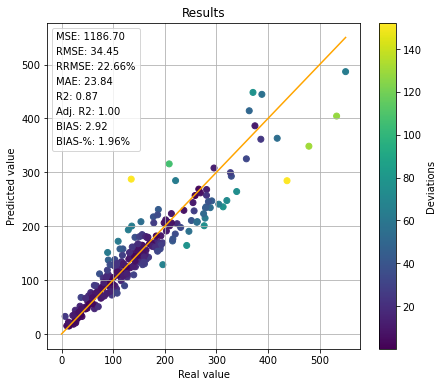

In [36]:
test_interp.plot_results()
plt.show()